<a href="https://colab.research.google.com/github/ChsQueen/Shocase/blob/master/setup_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

if torch.cuda.is_available():
   print("Your Colab notebook is configured to run on the GPU!")
else:
   print("If you see this message, your Colab notebook is currently running on the CPU. Click the Runtime dropdown menu, select Change runtime type, and  choose GPU in the list of Hardware accelerators")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Your Colab notebook is configured to run on the GPU!


In [8]:
train_set = torchvision.datasets.MNIST('../data', train=True,
download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.MNIST('../data', train=False,
transform=transforms.ToTensor())
# The DataLoader is an iterator that returns data in batches of a given size.
# You can also choose to have the data shuffled and to use multiple workers in parallel:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False, num_workers=4)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

 # nn.Conv2d is the 2D convolutional layer that takes in the following aruments,
 # some of which are optional:
 # (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
 # groups=1, bias=True, padding_mode='zeros')

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
 # nn.Linear(in_features, out_features, bias=True) is the fully connected layer
        self.fc1 = nn.Linear(in_features=320, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)

 # nn.MaxPool2d is a 2D max pool layer with the following aruments:
 # (kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

 # F.relu() is the REctified Linear Unit activation function
        x = F.relu(x)

        x = self.conv2(x)
        x = self.maxpool(x)
        x = F.relu(x)

 # The .view() method in torch works the same way as .reshape() does in numpy
        x = x.view(-1, 320)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
       
        return F.log_softmax(x)

# Make sure to specify that the network is to be run on the GPU
model = Net().to(device)
# torch.optim implements various optimization algorithms, such as SGD, Adam, etc
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [14]:
def train(model, device, train_loader, optimizer, epoch):

 # train() is the mode that "turns on" the non-deterministic layers
 # that may be present in the model (e.g. dropout, batchnorm, etc)
 model.train()

 epoch_loss = 0

 for batch_idx, (data, target) in enumerate(train_loader):

 # Don't forget to transfer the data to the GPU as well
     data, target = data.to(device), target.to(device)

     optimizer.zero_grad()
     output = model(data)
     loss = F.nll_loss(output, target)
     loss.backward()
     optimizer.step()

     if batch_idx % 300 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item())) 
        epoch_loss += loss.item()

 return epoch_loss
def test(model, device, test_loader):

 # eval() is the mode that "turns off" the non-deterministic layers
 # that may be present in the model (e.g. dropout, batchnorm, etc)
 model.eval()

 test_loss = 0
 correct = 0

 with torch.no_grad():
     for data, target in test_loader:
         data, target = data.to(device), target.to(device)
         output = model(data)
         test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
         pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
         correct += pred.eq(target.view_as(pred)).sum().item()
         test_loss /= len(test_loader.dataset)
         print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

         return test_loss, (100. * correct / len(test_loader.dataset)) 
train_losses = []
test_losses = []
test_accuracies = []
num_epochs = 30

for epoch in range(1, num_epochs+1):
    train_losses.append(train(model, device, train_loader, optimizer, epoch))
    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300513
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.108233
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.523179
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.395986

Test set: Average loss: 0.0526, Accuracy: 830/10000 (8%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.474361
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.157272
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.185882
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.331415

Test set: Average loss: 0.0274, Accuracy: 914/10000 (9%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.165393
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.132255
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.319974
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.199399

Test set: Average loss: 0.0187, Accuracy: 942/10000 (9%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.146603
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.047398
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.067280
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.113599

Test set: Average loss: 0.0143, Accuracy: 

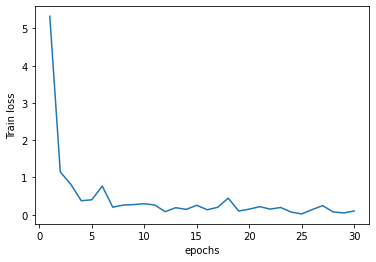

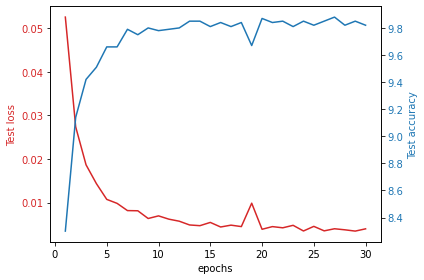

In [16]:
plt.plot(range(1, num_epochs+1), np.array(train_losses))
plt.ylabel('Train loss')
plt.xlabel('epochs')
plt.show()
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('Test loss', color=color)
ax1.plot(range(1, num_epochs+1), np.array(test_losses), color=
color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Test accuracy', color=color)
ax2.plot(range(1, num_epochs+1), np.array(test_accuracies), color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()